<a href="https://colab.research.google.com/github/gabie0208/nlp-study/blob/main/6_1_Seq2Seq_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chap 6. 챗봇 만들기 (Seq2Seq 모델)

직접 문장을 생성할 수 있는 text generation 문제를 실습해보자.

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
!pip install konlpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from konlpy.tag import Okt
from functools import reduce
from wordcloud import WordCloud

In [4]:
DATA_IN_PATH = '/content/drive/MyDrive/data_in/KOR/'

# 데이터 길이 분석

In [5]:
data = pd.read_csv(DATA_IN_PATH + 'ChatBotData.csv', encoding='utf-8')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [11]:
print(data.head(50))

                          Q  ... label
0                    12시 땡!  ...     0
1               1지망 학교 떨어졌어  ...     0
2              3박4일 놀러가고 싶다  ...     0
3           3박4일 정도 놀러가고 싶다  ...     0
4                   PPL 심하네  ...     0
5                 SD카드 망가졌어  ...     0
6                   SD카드 안돼  ...     0
7            SNS 맞팔 왜 안하지ㅠㅠ  ...     0
8   SNS 시간낭비인 거 아는데 매일 하는 중  ...     0
9         SNS 시간낭비인데 자꾸 보게됨  ...     0
10      SNS보면 나만 빼고 다 행복해보여  ...     0
11                   가끔 궁금해  ...     0
12              가끔 뭐하는지 궁금해  ...     0
13              가끔은 혼자인게 좋다  ...     0
14                가난한 자의 설움  ...     0
15               가만 있어도 땀난다  ...     0
16               가상화폐 쫄딱 망함  ...     0
17               가스불 켜고 나갔어  ...     0
18           가스불 켜놓고 나온거 같아  ...     0
19           가스비 너무 많이 나왔다.  ...     0
20          가스비 비싼데 감기 걸리겠어  ...     0
21                가스비 장난 아님  ...     0
22             가장 확실한 건 뭘까?  ...     0
23             가족 여행 가기로 했어  ...     0
24                 가족 여행 

## 문장 전체에 대한 분석 - 음절, 어절, 형태소 단위

질문과 답변 모두에 대해 길이를 분석하기 위해 두 데이터를 하나의 리스트로 만든다

In [13]:
sentences = list(data['Q']) + list(data['A'])

분석 기준은 다음과 같다

문자 단위의 길이 분석(음절), 단어 단위의 길이 분석(어절), 형태소 단위의 길이 분석

In [14]:
tokenized_sentences = [s.split() for s in sentences]
sent_len_by_token = [len(t) for t in tokenized_sentences]
sent_len_by_eumjeol = [len(s.replace(' ', '')) for s in sentences]

from konlpy.tag import Twitter

okt = Okt()

morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in sentences]
sent_len_by_morph = [len(t) for t in morph_tokenized_sentences]

matplotlib을 통해 어절, 형태소, 음절에 대한 히스토그램을 살펴본다

Text(0, 0.5, 'Number of Sentences')

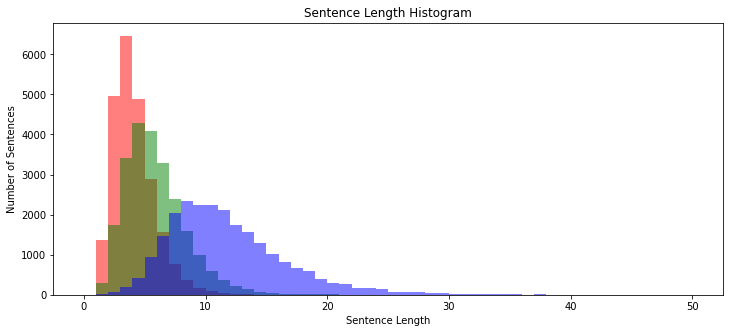

In [15]:
plt.figure(figsize=(12, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color= 'r', label='eojeol')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='g', label='morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5, color='b', label='eumjeol')
plt.title('Sentence Length Histogram')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

yscale 함수의 인자로 log를 사용하여 y값의 스케일을 조정한다

Text(0, 0.5, 'Number of Sentences')

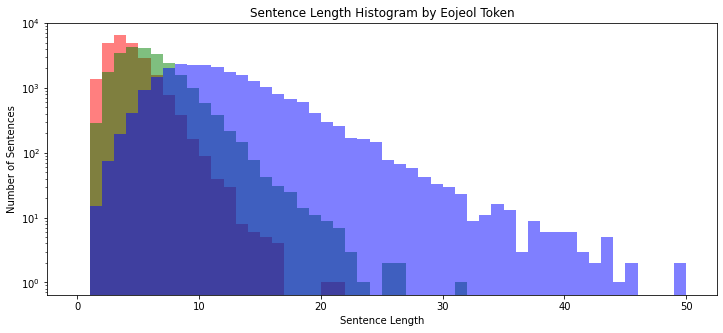

In [16]:
plt.figure(figsize=(12, 5))
plt.hist(sent_len_by_token, bins=50, range=[0,50], alpha=0.5, color= 'r', label='eojeol')
plt.hist(sent_len_by_morph, bins=50, range=[0,50], alpha=0.5, color='g', label='morph')
plt.hist(sent_len_by_eumjeol, bins=50, range=[0,50], alpha=0.5, color='b', label='eumjeol')
plt.yscale('log')
plt.title('Sentence Length Histogram by Eojeol Token')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')

어절, 형태소, 음절에 대한 통곗값을 출력해보자

In [17]:
print('어절 최대길이: {}'.format(np.max(sent_len_by_token)))
print('어절 최소길이: {}'.format(np.min(sent_len_by_token)))
print('어절 평균길이: {:.2f}'.format(np.mean(sent_len_by_token)))
print('어절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_token)))
print('어절 중간길이: {}'.format(np.median(sent_len_by_token)))
print('제 1 사분위 길이: {}'.format(np.percentile(sent_len_by_token, 25)))
print('제 3 사분위 길이: {}'.format(np.percentile(sent_len_by_token, 75)))

어절 최대길이: 21
어절 최소길이: 1
어절 평균길이: 3.64
어절 길이 표준편차: 1.74
어절 중간길이: 3.0
제 1 사분위 길이: 2.0
제 3 사분위 길이: 5.0


In [18]:
print('형태소 최대길이: {}'.format(np.max(sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_morph, 75)))

형태소 최대길이: 31
형태소 최소길이: 1
형태소 평균길이: 5.41
형태소 길이 표준편차: 2.56
형태소 중간길이: 5.0
형태소 1/4 퍼센타일 길이: 4.0
형태소 3/4 퍼센타일 길이: 7.0


In [19]:
print('음절 최대길이: {}'.format(np.max(sent_len_by_eumjeol)))
print('음절 최소길이: {}'.format(np.min(sent_len_by_eumjeol)))
print('음절 평균길이: {:.2f}'.format(np.mean(sent_len_by_eumjeol)))
print('음절 길이 표준편차: {:.2f}'.format(np.std(sent_len_by_eumjeol)))
print('음절 중간길이: {}'.format(np.median(sent_len_by_eumjeol)))
print('음절 1/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_eumjeol, 25)))
print('음절 3/4 퍼센타일 길이: {}'.format(np.percentile(sent_len_by_eumjeol, 75)))

음절 최대길이: 57
음절 최소길이: 1
음절 평균길이: 11.31
음절 길이 표준편차: 4.98
음절 중간길이: 10.0
음절 1/4 퍼센타일 길이: 8.0
음절 3/4 퍼센타일 길이: 14.0


전체 데이터를 한 눈에 보기 쉽게 박스 플롯으로 그려보자

{'boxes': [<matplotlib.lines.Line2D at 0x7f1fb9fa1610>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1fb9ef5c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1fb9ecbbd0>,
 'means': [<matplotlib.lines.Line2D at 0x7f1fb9df5850>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1fb9f0e710>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1fb9f39210>,
  <matplotlib.lines.Line2D at 0x7f1fb9df7950>]}

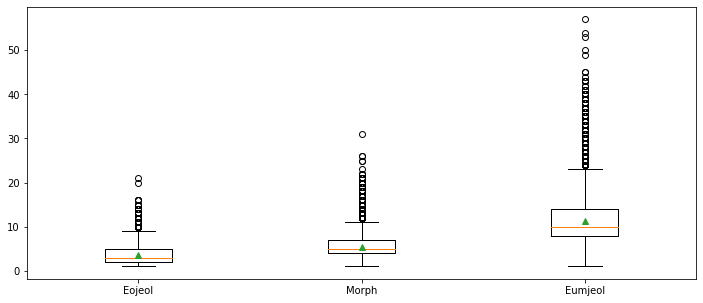

In [13]:
plt.figure(figsize=(12, 5))
plt.boxplot([sent_len_by_token, sent_len_by_morph, sent_len_by_eumjeol],
            labels=['Eojeol', 'Morph', 'Eumjeol'], 
            showmeans=True)

## 질문, 답변 각각에 대한 문장 길이 분포 분석 - 형태소 단위

In [20]:
query_sentences = list(data['Q'])
answer_sentences = list(data['A'])

query_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in query_sentences]
query_sent_len_by_morph = [len(t) for t in query_morph_tokenized_sentences]

answer_morph_tokenized_sentences = [okt.morphs(s.replace(' ', '')) for s in answer_sentences]
answer_sent_len_by_morph = [len(t) for t in answer_morph_tokenized_sentences]

Text(0, 0.5, 'Number of Queries')

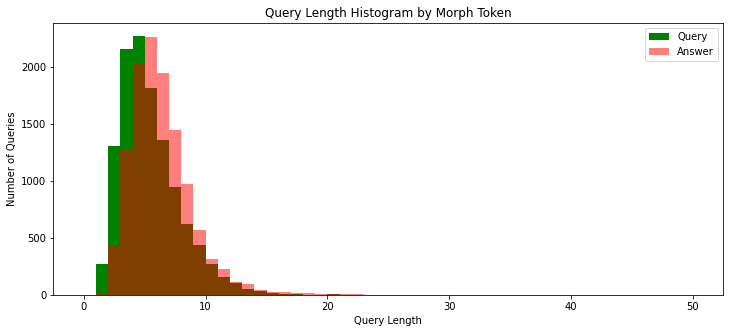

In [21]:
plt.figure(figsize=(12, 5))
plt.hist(query_sent_len_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.title('Query Length Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

yscale 함수로 y값 크기 조정 후 결과를 재확인한다

Text(0, 0.5, 'Number of Queries')

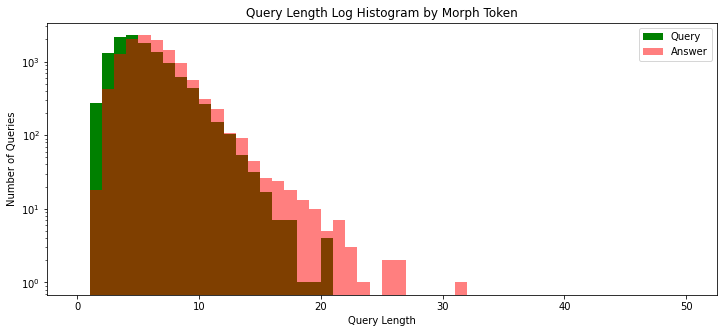

In [22]:
plt.figure(figsize=(12, 5))
plt.hist(query_sent_len_by_morph, bins=50, range=[0,50], color='g', label='Query')
plt.hist(answer_sent_len_by_morph, bins=50, range=[0,50], color='r', alpha=0.5, label='Answer')
plt.legend()
plt.yscale('log', nonposy='clip')
plt.title('Query Length Log Histogram by Morph Token')
plt.xlabel('Query Length')
plt.ylabel('Number of Queries')

질문, 답변 데이터에 대한 통곗값

In [17]:
print('형태소 최대길이: {}'.format(np.max(query_sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(query_sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(query_sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(query_sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(query_sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(query_sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(query_sent_len_by_morph, 75)))

형태소 최대길이: 20
형태소 최소길이: 1
형태소 평균길이: 4.95
형태소 길이 표준편차: 2.48
형태소 중간길이: 4.0
형태소 1/4 퍼센타일 길이: 3.0
형태소 3/4 퍼센타일 길이: 6.0


In [18]:
print('형태소 최대길이: {}'.format(np.max(answer_sent_len_by_morph)))
print('형태소 최소길이: {}'.format(np.min(answer_sent_len_by_morph)))
print('형태소 평균길이: {:.2f}'.format(np.mean(answer_sent_len_by_morph)))
print('형태소 길이 표준편차: {:.2f}'.format(np.std(answer_sent_len_by_morph)))
print('형태소 중간길이: {}'.format(np.median(answer_sent_len_by_morph)))
print('형태소 1/4 퍼센타일 길이: {}'.format(np.percentile(answer_sent_len_by_morph, 25)))
print('형태소 3/4 퍼센타일 길이: {}'.format(np.percentile(answer_sent_len_by_morph, 75)))

형태소 최대길이: 31
형태소 최소길이: 1
형태소 평균길이: 5.87
형태소 길이 표준편차: 2.55
형태소 중간길이: 5.0
형태소 1/4 퍼센타일 길이: 4.0
형태소 3/4 퍼센타일 길이: 7.0


{'boxes': [<matplotlib.lines.Line2D at 0x7f1fb8e7ebd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1fb8e9e450>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1fb8e3fa90>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f1fb8e7f790>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f1fb9e0b790>,
  <matplotlib.lines.Line2D at 0x7f1fb8db1210>]}

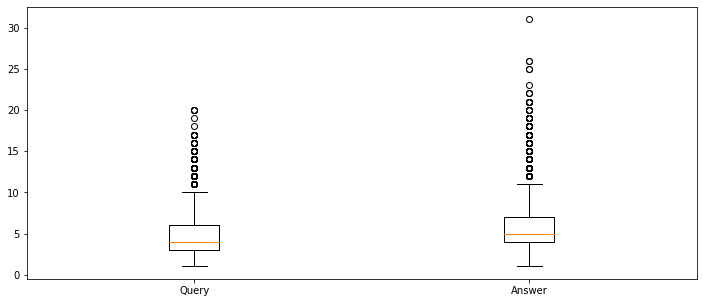

In [19]:
plt.figure(figsize=(12,5))
plt.boxplot([query_sent_len_by_morph, answer_sent_len_by_morph], labels=['Query', 'Answer'])

# 데이터 어휘 빈도 분석

## POS-tagging 품사 분류

In [20]:
okt.pos('오늘밤은유난히덥구나')

[('오늘밤', 'Noun'), ('은', 'Josa'), ('유난히', 'Adverb'), ('덥구나', 'Adjective')]

각 문장에서 명사, 형용사, 동사를 제외한 단어를 모두 제거한다

In [21]:
query_NVA_token_sentences = list()
answer_NVA_token_sentences = list()

for s in query_sentences:
    for token, tag in okt.pos(s.replace(' ', '')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            query_NVA_token_sentences.append(token)

for s in answer_sentences:
    temp_token_bucket = list()
    for token, tag in okt.pos(s.replace(' ', '')):
        if tag == 'Noun' or tag == 'Verb' or tag == 'Adjective':
            answer_NVA_token_sentences.append(token)
            
query_NVA_token_sentences = ' '.join(query_NVA_token_sentences)
answer_NVA_token_sentences = ' '.join(answer_NVA_token_sentences)

워드클라우드를 통해 데이터의 어휘 빈도를 분석한다

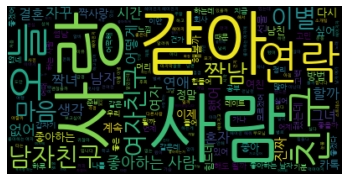

In [22]:
query_wordcloud = WordCloud(font_path= DATA_IN_PATH + 'NanumGothic.ttf').generate(query_NVA_token_sentences)

plt.imshow(query_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

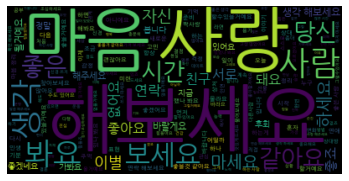

In [23]:
answer_wordcloud = WordCloud(font_path= DATA_IN_PATH + 'NanumGothic.ttf').generate(answer_NVA_token_sentences)

plt.imshow(answer_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 시퀀스 투 시퀀스 모델

## 모델 소개

이름 그대로 시퀀스 형태의 입력값을 시퀀스 형태의 출력으로 만들 수 있게 하는 모델이다

즉, 하나의 텍스트 문장이 input으로 들어오면 하나의 텍스트 문장의 output을 만드는 것이다

가장 많이 활용되는 분야는 기계 번역, 텍스트 요약, 이미지 설명, 대화 모델 등이 있다

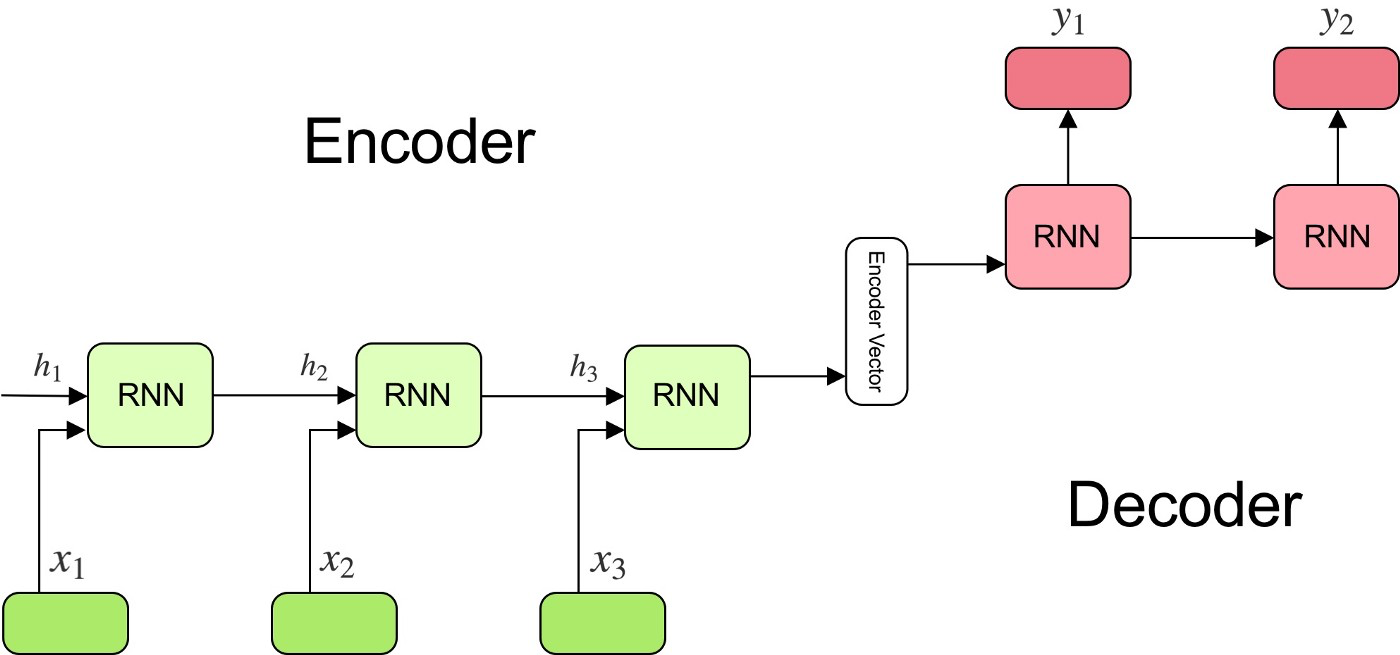

RNN(Recurrent Neural Networks) 순환신경망 모델을 기반으로 하며, 모델은 크게 인코더와 디코더 부분으로 나뉜다.

우선 인코더에서 입력값을 받아 입력값의 정보를 담은 벡터를 생성한다.

이후 디코더에서 이 벡터를 활용해 재귀적으로 출력값을 만들어낸다.

## preprocess.py 데이터 전처리

In [24]:
import os
import re
import json

import numpy as np
import pandas as pd
from tqdm import tqdm

from konlpy.tag import Okt

정규표현식에서 사용할 필터와 special tokens의 인덱스 값을 지정한다

In [25]:
FILTERS = "([~.,!?\"':;)(])"
PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

MAX_SEQUENCE = 25

load_data 함수는 pandas를 통해 데이터를 불러와 DataFrame 형태로 만든 후 question과 answer을 돌려준다

In [26]:
def load_data(path):
    data_df = pd.read_csv(path, header=0)
    question, answer = list(data_df['Q']), list(data_df['A'])
    
    return question, answer

data_tokenizer 함수로 전처리를 거친 단어 리스트를 만든다

In [27]:
def data_tokenizer(data):
    words = []

    for sentence in data:
        sentence = re.sub(CHANGE_FILTER, "", sentence)

        for word in sentence.split():
            words.append(word)
            
    return [word for word in words if word]

prepro_like_morphlized 함수는 토크나이징을 위해 형태소로 분리한다

In [28]:
def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data

load_vocabulary 함수는 단어 사전을 만든다

In [29]:
def load_vocabulary(path, vocab_path, tokenize_as_morph=False):
    vocabulary_list = []

    if not os.path.exists(vocab_path):
        if (os.path.exists(path)):
            data_df = pd.read_csv(path, encoding='utf-8')
            question, answer = list(data_df['Q']), list(data_df['A'])
            if tokenize_as_morph: 
                question = prepro_like_morphlized(question)
                answer = prepro_like_morphlized(answer)
            data = []
            data.extend(question)
            data.extend(answer)
            
            words = data_tokenizer(data)
            words = list(set(words))
            words[:0] = MARKER
        
        with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word + '\n')

    with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())

    char2idx, idx2char = make_vocabulary(vocabulary_list)
    
    return char2idx, idx2char, len(char2idx)

vocabulary_list = [안녕, 너는, 누구야]

word2idx의 key-value = {안녕':0, '너는':1, '누구야':2}

idx2word의 key-value = {0:'안녕', 1:'너는', 2:'누구야'}


In [30]:
def make_vocabulary(vocabulary_list):
    char2idx = {char: idx for idx, char in enumerate(vocabulary_list)}
    idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}
    return char2idx, idx2char

enc_processing 함수는 인코더에 적용될 입력값을 만드는 전처리 함수다

In [31]:
def enc_processing(value, dictionary, tokenize_as_morph=False):
    sequences_input_index = []
    sequences_length = []
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = []
      
        for word in sequence.split():  
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            else:
                sequence_index.extend([dictionary[UNK]])
       
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        
        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_input_index.append(sequence_index)
    return np.asarray(sequences_input_index), sequences_length

dec_output_processing 함수는 디코더의 입력값을 만드는 함수다

In [32]:
def dec_output_processing(value, dictionary, tokenize_as_morph=False):
  
    sequences_output_index = []
    sequences_length = []
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = []
        sequence_index = [dictionary[STD]] + [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
        
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        
        sequences_length.append(len(sequence_index))
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_output_index.append(sequence_index)
    return np.asarray(sequences_output_index), sequences_length

dec_target_processing 함수는 디코더의 target 값을 만드는 함수다

In [33]:
def dec_target_processing(value, dictionary, tokenize_as_morph=False):
  
    sequences_target_index = []
    
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    
    for sequence in value:
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        sequence_index = [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
      
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
      
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        sequences_target_index.append(sequence_index)
    return np.asarray(sequences_target_index)

In [34]:
PATH = '/content/drive/MyDrive/data_in/KOR/ChatBotData.csv_short'
VOCAB_PATH = '/content/drive/MyDrive/data_in/KOR/vocabulary.txt'

In [35]:
inputs, outputs = load_data(PATH)
char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH, tokenize_as_morph=False)

In [36]:
index_inputs, input_seq_len = enc_processing(inputs, char2idx, tokenize_as_morph=False)
index_outputs, output_seq_len = dec_output_processing(outputs, char2idx, tokenize_as_morph=False)
index_targets = dec_target_processing(outputs, char2idx, tokenize_as_morph=False)

In [37]:
data_configs = {}
data_configs['char2idx'] = char2idx
data_configs['idx2char'] = idx2char
data_configs['vocab_size'] = vocab_size
data_configs['pad_symbol'] = PAD
data_configs['std_symbol'] = STD
data_configs['end_symbol'] = END
data_configs['unk_symbol'] = UNK

In [38]:
DATA_IN_PATH = '/content/drive/MyDrive/data_in/KOR/'

TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

np.save(open(DATA_IN_PATH + TRAIN_INPUTS, 'wb'), index_inputs)
np.save(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'wb'), index_outputs)
np.save(open(DATA_IN_PATH + TRAIN_TARGETS , 'wb'), index_targets)

json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'))

In [39]:
char2idx

{'<END>': 2,
 '<PAD>': 0,
 '<SOS>': 1,
 '<UNK>': 3,
 '가끔': 47,
 '가끔은': 90,
 '가난한': 89,
 '가만': 66,
 '가상화폐': 34,
 '가스불': 65,
 '가스비': 6,
 '감기': 13,
 '갔어': 30,
 '같아': 31,
 '같아요': 80,
 '거예요': 18,
 '거짓말': 86,
 '걸리겠어': 88,
 '것': 4,
 '게': 55,
 '결단은': 44,
 '교회': 78,
 '구하셨나요': 22,
 '궁금해': 107,
 '그': 106,
 '그럴': 100,
 '끄고': 98,
 '나': 7,
 '나갔어': 19,
 '나라를': 17,
 '나오세요': 91,
 '나온거': 110,
 '나왔다': 68,
 '남자친구': 12,
 '남자친구가': 75,
 '너무': 26,
 '다시': 69,
 '다음': 38,
 '달에는': 29,
 '더': 97,
 '데려가고': 56,
 '돈은': 20,
 '돌아가서': 9,
 '들어올': 16,
 '따뜻하게': 54,
 '따라': 32,
 '땀난다': 11,
 '땀을': 43,
 '때까지': 84,
 '또': 99,
 '마세요': 51,
 '마음을': 61,
 '많이': 64,
 '망함': 14,
 '뭐가': 104,
 '뭐하는지': 25,
 '뭘': 81,
 '믿어줘': 105,
 '바빠': 102,
 '보인다': 85,
 '비싼데': 35,
 '빠를수록': 95,
 '빨리': 79,
 '사람도': 5,
 '사세요': 94,
 '새출발': 70,
 '생각해보세요': 10,
 '생일인데': 40,
 '선물로': 23,
 '설득해보세요': 21,
 '설움': 109,
 '승진': 82,
 '식혀주세요': 8,
 '싶어': 46,
 '안': 62,
 '어서': 76,
 '열': 49,
 '오늘': 24,
 '운동': 45,
 '운동만': 58,
 '운동을': 83,
 '있어도': 52,
 '잊고': 60,
 '자의': 63,
 '잘생겼어': 

In [40]:
idx2char

{0: '<PAD>',
 1: '<SOS>',
 2: '<END>',
 3: '<UNK>',
 4: '것',
 5: '사람도',
 6: '가스비',
 7: '나',
 8: '식혀주세요',
 9: '돌아가서',
 10: '생각해보세요',
 11: '땀난다',
 12: '남자친구',
 13: '감기',
 14: '망함',
 15: '해',
 16: '들어올',
 17: '나라를',
 18: '거예요',
 19: '나갔어',
 20: '돈은',
 21: '설득해보세요',
 22: '구하셨나요',
 23: '선물로',
 24: '오늘',
 25: '뭐하는지',
 26: '너무',
 27: '해보세요',
 28: '혼자를',
 29: '달에는',
 30: '갔어',
 31: '같아',
 32: '따라',
 33: '함께',
 34: '가상화폐',
 35: '비싼데',
 36: '훈훈해',
 37: '좋을',
 38: '다음',
 39: '줄까',
 40: '생일인데',
 41: '전생에',
 42: '좋을까',
 43: '땀을',
 44: '결단은',
 45: '운동',
 46: '싶어',
 47: '가끔',
 48: '집에',
 49: '열',
 50: '좋다',
 51: '마세요',
 52: '있어도',
 53: '즐기세요',
 54: '따뜻하게',
 55: '게',
 56: '데려가고',
 57: '켜고',
 58: '운동만',
 59: '질린다',
 60: '잊고',
 61: '마음을',
 62: '안',
 63: '자의',
 64: '많이',
 65: '가스불',
 66: '가만',
 67: '혼자인게',
 68: '나왔다',
 69: '다시',
 70: '새출발',
 71: '필요한',
 72: '켜놓고',
 73: '필요했던',
 74: '좀',
 75: '남자친구가',
 76: '어서',
 77: '하세요',
 78: '교회',
 79: '빨리',
 80: '같아요',
 81: '뭘',
 82: '승진',
 83: '운동을',
 84: '때까지',
 85